<a href="https://colab.research.google.com/github/KozinIlya/Test-Study/blob/main/Voronka_ROMI_LTV_kogorty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЧТО ДОЛЖНО СОДЕРЖАТЬСЯ В ОТЧЁТЕ

График с событиями по дням и ответ на вопросы: В каком месте маркетинг работает недостаточно хорошо? За счёт чего можно расти?
График с распределением трафика (открытие приложения) по группам «Установили в тот же день» и «Остальные».
График с динамикой установок приложения по каналам привлечения и ответ на вопрос: С каких платных каналов приходит больше и меньше всего пользователей?
Анализ: на каком этапе воронки отваливается б'ольшая часть клиентов (отдельно для зарегистрированных и для незарегистрированных пользователей). Сформулируйте предложение по оптимизации.
Выбор лучшего и худшего каналов по конверсии в первую покупку.
Расчёт ROMI для всех каналов.
Таблица когорт (в абс. и %) по неделе первого посещения, выбор самой большой и самой активной когорт.
Таблица когорт (в абс. и %) по неделе первой покупки, выбор самой активной когорты и анализ динамики активности.
Расчёт среднего/медианного чека по когортам (недели первой покупки) в каждую неделю с момента первой покупки, указание диапазонов.

ссылка на исходный файл https://drive.google.com/file/d/18P3lErk4kZotMSS-N8oJ2-q2D6d_79GV/view?usp=sharing


#Загрузка и обработка

In [2]:
! gdown --id 18P3lErk4kZotMSS-N8oJ2-q2D6d_79GV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18P3lErk4kZotMSS-N8oJ2-q2D6d_79GV
To: /content/SF_case_data.csv
100% 175M/175M [00:01<00:00, 90.8MB/s]


In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/SF_case_data.csv')
data.head(2)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads


In [4]:
#создание групп «Установили в тот же день» и «Остальные»
installs = data[data['event'] == 'app_install']
data['install_date'] = data['device_id'].map(installs.set_index('device_id')['date'])
def new_column(date1,date2,value):
    if date1 == date2:
        return value
data['install_group'] = data.apply(lambda x: new_column(date1 = x['date'], date2 = x['install_date'], value = 'Установили в этот же день'), axis=1)
data['install_group'] = data['install_group'].fillna('Остальные')


In [5]:
#вычесление данных по дням и создание общего датафрейма для дашборда
df = data[data['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users') # ко-во «Установили в тот же день» и «Остальные»
df1 = data.groupby(['date','event'])['event'].count().reset_index(name = 'users') # кол-во по виду действия
df2 = data[data['event'] == 'app_install'].groupby(['date','utm_source']).size().reset_index(name = 'users') # кол-во инсталов по каналу привлечения

# кросстэйбл датафреймов
install_group = pd.crosstab(df.date, df.install_group, values=df.users, aggfunc=np.average).reset_index()
event_group = pd.crosstab(df1.date, df1.event, values=df1.users, aggfunc=np.average).reset_index()
source_group = pd.crosstab(df2.date, df2.utm_source, values=df2.users, aggfunc=np.average).reset_index()

#мердж по дате 
m_df = pd.merge(install_group, event_group)
merge_df = pd.merge(m_df, source_group)
merge_df.head(2)

,date,Остальные,Установили в этот же день,app_install,app_start,choose_item,purchase,register,search,tap_basket,-,facebook_ads,google_ads,instagram_ads,referal,vk_ads,yandex-direct
0,2020-01-01,866,3579,3579,4445,3246,907,1059,4243,2302,761,337,617,422,218,555,669
1,2020-01-02,1957,3144,3144,5101,3747,1031,1145,4822,2650,674,277,525,408,207,463,590


##Выгрузка датафрейма на ГД

In [6]:
#выгрузка датафрейма на гуглдиск для создания дашборда
from google.colab import drive
drive.mount('drive')
merge_df.to_csv('merge_df.csv')
!cp merge_df.csv "drive/My Drive/"

# дашборд https://datastudio.google.com/s/jSHnR39f8TI

Mounted at drive


#Дашборд  с событиями по дням, динамикой установок приложения по каналам привлечения   и выводы.

дашборд https://datastudio.google.com/s/jSHnR39f8TI


Выводы на основании данных дашборда:

1.На графике "события по дням" заметен нисходящий тренд по большинству видов событий.  Особые опасения вызывает эта динамика в событиях типа "открытие приложения" и "поиск" так как свидетельствует о снижениии повторного использования сервиса. Так же стоит обратить внимание на отсутствие выраженной положительной динимики между событиями входящими в воронку продаж.

2. на графике динамики привлечения пользователей по каналам видно что наиболее эффективным является  yandex-direct, наименее - facebook_ads

#Воронка продаж

In [7]:
# маркировка действий для зарегистрированных и незарегистрированных пользователей
first_registration = data[data['event'] == 'register'].sort_values('date').drop_duplicates('device_id')
first_registration['finally_registered'] = 1
data['first_registration'] = data['device_id'].map(first_registration.set_index('device_id')['date'])
data['finally_registered'] = data['device_id'].map(first_registration.set_index('device_id')['finally_registered'])
already_reg = data[data['first_registration'] < data['date']]
already_reg['registered'] = 1
requires_reg1 = data[(data['first_registration'].isna() == True)]
requires_reg1['registered'] = 0
requires_reg2 =  data[data['first_registration'] >= data['date']]
requires_reg2['registered'] = 0
data = pd.concat([already_reg,requires_reg1,requires_reg2])
data[data['event'] == 'tap_basket'].groupby('registered').count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,install_group,first_registration,finally_registered
registered,,,,,,,,,,,,
0,160409,160409,0,160409,160409,160409,160409,160409,130022,160409,105031,105031
1,217256,217256,0,217256,217256,217256,217256,217256,177108,217256,217256,217256


In [8]:
#воронка продаж для разных источников привлечения зарегестрированные пользователи
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)
funnel_reg['1 step'] = funnel_reg['search']*100/funnel_reg['app_start']
funnel_reg['2 step'] = funnel_reg['choose_item']*100/funnel_reg['search']
funnel_reg['3 step'] = funnel_reg['tap_basket']*100/funnel_reg['choose_item']
funnel_reg['5 step'] = funnel_reg['purchase']*100/funnel_reg['tap_basket']


In [9]:
#воронка продаж для разных источников привлечения незарегестрированные пользователи
not_reg = data[data['registered'] == 0]
funnel_not_reg = pd.crosstab(not_reg.utm_source, not_reg.event, values=not_reg.device_id, aggfunc=pd.Series.nunique)
funnel_not_reg['1 step'] = funnel_not_reg['search']*100/funnel_not_reg['app_start']
funnel_not_reg['2 step'] = funnel_not_reg['choose_item']*100/funnel_not_reg['search']
funnel_not_reg['3 step'] = funnel_not_reg['tap_basket']*100/funnel_not_reg['choose_item']
funnel_not_reg['4 step'] = funnel_not_reg['register']*100/funnel_not_reg['tap_basket']
funnel_not_reg['5 step'] = funnel_not_reg['purchase']*100/funnel_not_reg['register']


In [10]:
#конверсия в первую покупку
first_opens = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
first_purchase = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')

stat = first_opens.merge(first_purchase, how = 'left', on = 'utm_source')
stat['CR to first purchase'] = stat['users_y']/stat['users_x']
c_to_f_p = stat.sort_values('CR to first purchase')

In [11]:
print('Для незарегестрированных пользователей:')
print(funnel_not_reg)
print()
print()
print()
print('Для зарегестрированных пользователей:')
print(funnel_reg)
print()
print()
print()
print('Конверсия в первую покупку:')
print(c_to_f_p)

Для незарегестрированных пользователей:
event          app_install  app_start  choose_item  purchase  register  \
utm_source                                                               
-                    32460      48670        38026     14073     16527   
facebook_ads         13916      23780        18713      7506      8672   
google_ads           26286      35778        27416      9777     11405   
instagram_ads        20096      29237        22858      9394     10750   
referal               9282      14866        11880      5503      6193   
vk_ads               23189      32353        25422     10919     12421   
yandex-direct        29368      38578        29591     10581     12342   

event          search  tap_basket     1 step     2 step     3 step     4 step  \
utm_source                                                                      
-               46742       29223  96.038627  81.352959  76.850050  56.554769   
facebook_ads    22822       14592  95.971405  81.9

##Выводы
4. БОльшая часть клиентов отваливается на этапе покупки для зарегистрированных пользователей и на этапе регистрации для незарегестрированных пользователей. 

  Рекомендую настроить систему напоминания об оставленном в корзине товаре и провести работу по поиску узких мест в процедуре регистрации.Как вариант, проверить на каком этапе регистрации клиент останавливается.

5. Конверсия в первую покупку. Лучший  канал реферальная программа. Худший - Яндекс директ. 

#ROMI

In [12]:
#ROMI
s = data[data['event'] == 'purchase'].groupby(['utm_source'])[['purchase_sum']].sum().reset_index()
referal_marketing_cost = data[data['event']=='purchase'].drop_duplicates('device_id')['utm_source'].value_counts()['referal'] *200
s["marketing_cost"] = [0, 8590498, 10534878, 8561626, referal_marketing_cost, 9553531, 10491707]
s['ROMI'] = (s['purchase_sum']-s['marketing_cost'])*100/s['marketing_cost']
s.drop(index=[0]).sort_values(['ROMI'], ascending=False).round(2)

,utm_source,purchase_sum,marketing_cost,ROMI
4,referal,8837044.5,1174800,652.22
5,vk_ads,16389652.5,9553531,71.56
3,instagram_ads,14546969.0,8561626,69.91
1,facebook_ads,12249901.0,8590498,42.60
6,yandex-direct,13915368.0,10491707,32.63
2,google_ads,12868276.0,10534878,22.15


#Когорты и LTV

##Когорты по первой покупке и первому посещению

In [16]:
# когорты по неделе первого посещения
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
entrances = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id')
data['first_entrance'] = data['device_id'].map(entrances.set_index('device_id')['date'])
data['first_entrance'] = pd.to_datetime(data['first_entrance'], format = '%Y-%m-%d')
data['first_entrance_cohort'] = data['first_entrance'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['n_week'] = data['date'] - data['first_entrance_cohort']
data['n_week'] = data['n_week'].apply(lambda x: x.days // 7 )
data['first_entrance_cohort'] = data['first_entrance_cohort'].apply(lambda x: str(x)[:10])


In [17]:
# когорты по неделе первой покупки 
entrances = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
data['first_purchase'] = data['device_id'].map(entrances.set_index('device_id')['date'])
data['first_purchase'] = pd.to_datetime(data['first_entrance'], format = '%Y-%m-%d')
data['first_purchase_cohort'] = data['first_entrance'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['n_week'] = data['date'] - data['first_purchase_cohort']
data['n_week'] = data['n_week'].apply(lambda x: x.days // 7 )
data['first_purchase_cohort'] = data['first_purchase_cohort'].apply(lambda x: str(x)[:10])

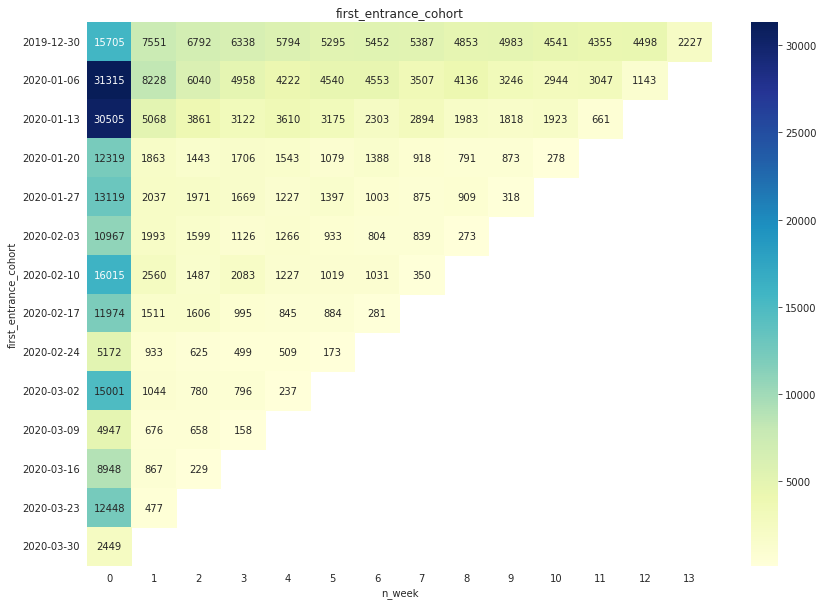

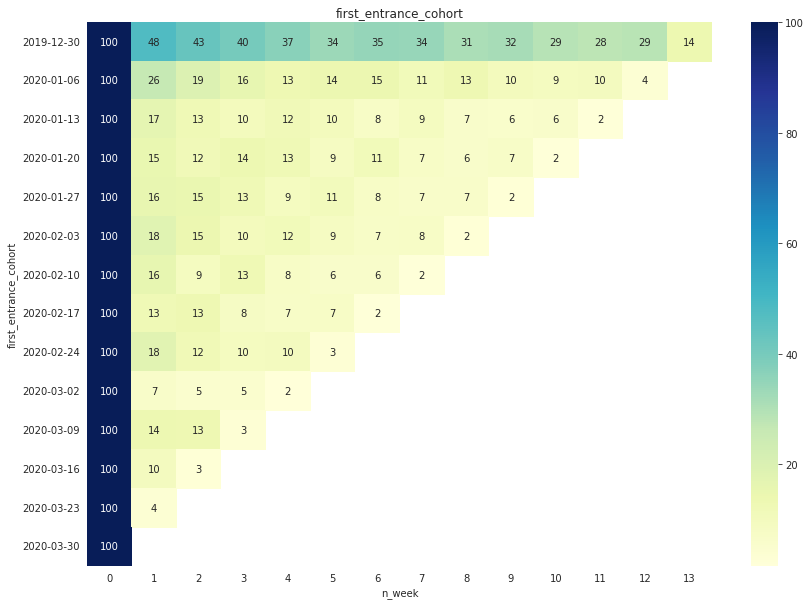

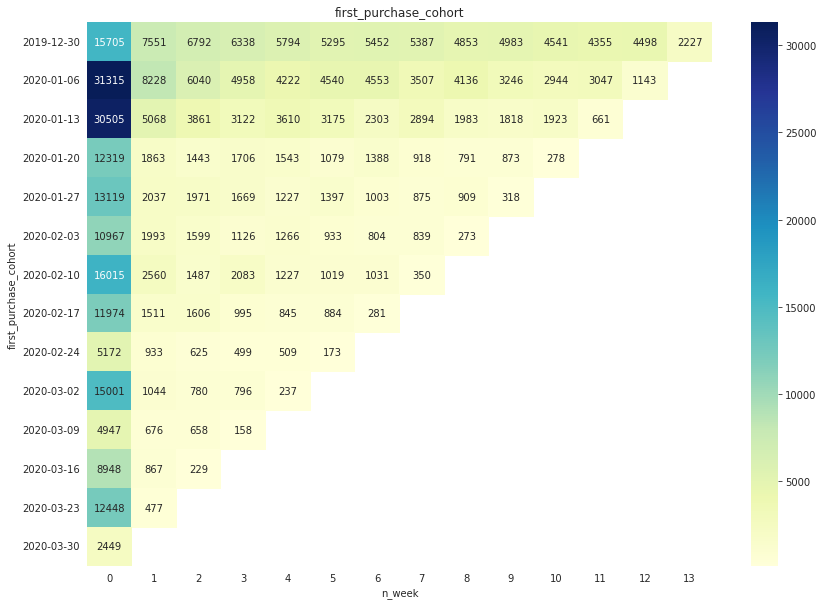

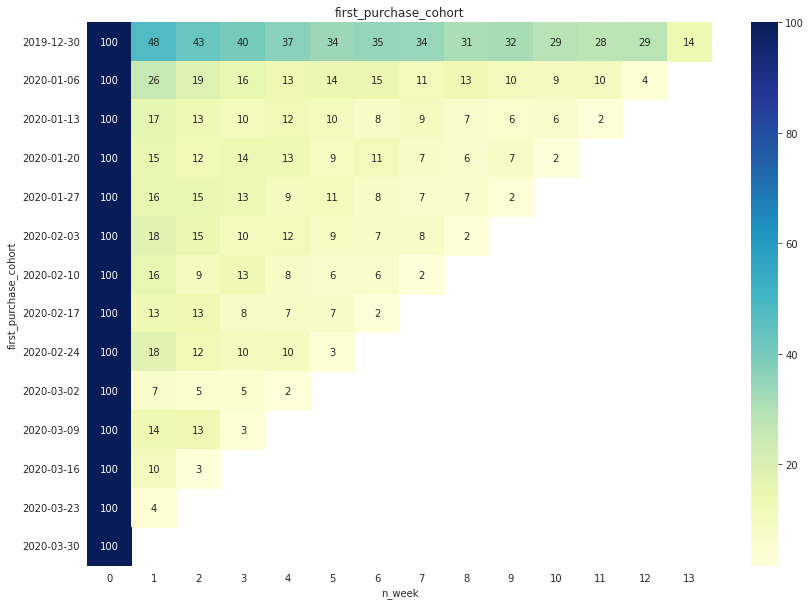

In [18]:
s = ['first_entrance_cohort', 'first_purchase_cohort']
for i in s:
  viz = data.pivot_table(
                          index= i, 
                          columns='n_week', 
                          values='device_id', 
                          aggfunc=pd.Series.nunique)

  with sns.axes_style("white"):
      f, ax = plt.subplots(figsize=(14, 10))
      ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");
  ax.set_title(i)    
  viz = viz.apply(lambda x: x*100/viz[0])
  with sns.axes_style("white"):
      f, ax = plt.subplots(figsize=(14, 10))
      ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");
  ax.set_title(i)

##LTV

In [ ]:
from datetime import timedelta
purchases = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
data['first_purchase'] = data['device_id'].map(purchases.set_index('device_id')['date'])
data['first_purchase'] = pd.to_datetime(data['first_purchase'], format = '%Y-%m-%d')
df = data[-data['first_purchase'].isna()]
df['first_purchase_cohort'] = df['first_purchase'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['n_week'] = df['date'] - df['first_purchase_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['first_purchase_cohort'] = df['first_purchase_cohort'].apply(lambda x: str(x)[:10])

df = df[df['event'] == 'purchase']
df.groupby('first_purchase_cohort')['purchase_sum'].sum().reset_index(name = 'LTV').sort_values('LTV', ascending = False)

##Когорты с медианным и средним чеком

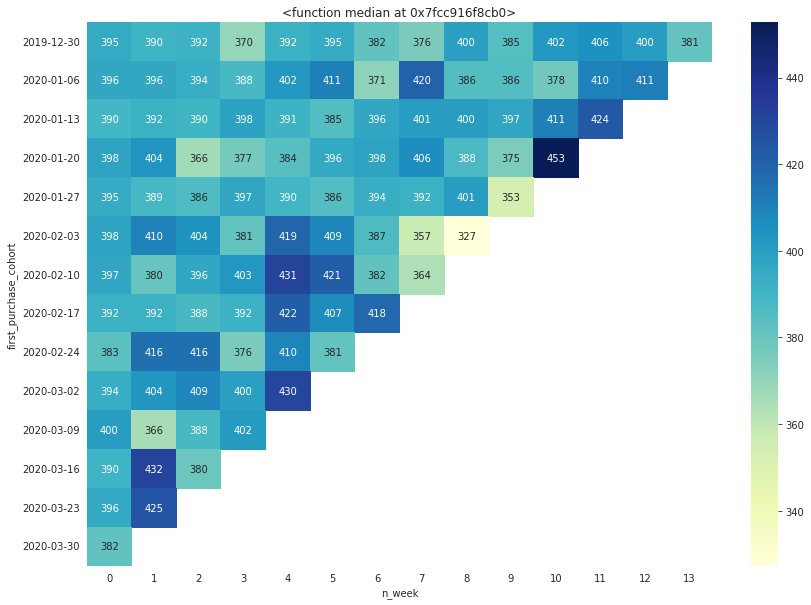

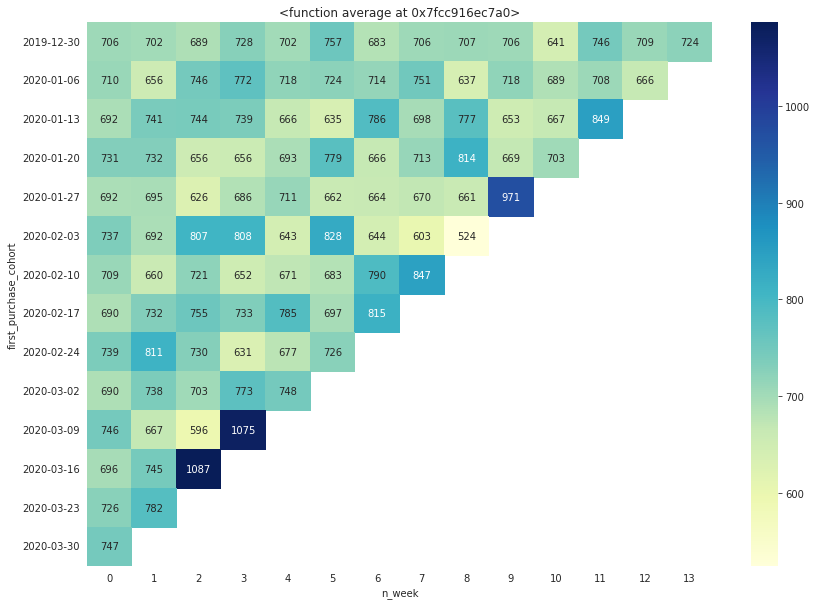

In [22]:
j = [np.median, np.average]
for i in j:
  viz = df.pivot_table(
                          index='first_purchase_cohort', 
                          columns='n_week', 
                          values='purchase_sum', 
                          aggfunc= i)

  with sns.axes_style("white"):
      f, ax = plt.subplots(figsize=(14, 10))
      ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu")
      ax.set_title(i);

##Вывод

7. Когорты по неделе первого посещения:

самая большая 06.01.2020

самая активая 30.12.2019

8. Когорты по неделе первой покупки:

самая активая 30.12.2019

Данные когортного анализа показывают что повторные покупки совершают менее 20% клиентов. так же отчетливо видно что в более поздних когортах отток клиентов проходит интенсивнее.


Общий вывод:

У сервиса есть большая проблема с удержанием клиентов. Необходимо переработать систему регистрации и активизировать работу по мотивации клиентов к повторным покупкам.